# Restaurant Recommendation Project #

### Nick Alexander ###

# Introduction #

The audience is a hospitality company that manages many restaurants around the US. This company wants to open a new restaurant and maximize the likelihood of the success of this restaurant. This analysis will recommend a location to open up a restaurant. This company is relatively conservative, in that it favors a large, established, growing market over a small, possibly faster growing market. This project takes on a broad scope in that is considers all major cities in the country. I will assess all major population centers in the country to identify which cities may be underserved, from a gastronomic perspective. I assess the potential locations based on three categories: 2019 population, population growth and number of food venues as a percentage of total venues. Next, I will choose one city, and identify which types of restaurants might add an exciting element to their restaurant scene. Finally, I will conduct location-based clustering and recommend a specific cluster associated with a location to open in the target city.

Three different data sources will be utilized. First, data from the largest cities in the US is scraped from Wikipedia. Next, the zip codes from the filtered cities is downloaded from a Zip Code API web service. Once all the zip codes for each city have been obtained, they will be appended with their corresponding latitude and longitude. Finally, the venues associated with these zip codes will be extracted from Foursquare. The data from Foursquare will be analyzed to make the final recommendation.

In [1]:
import pandas as pd
import pdb
import numpy as np
import requests
import urllib
import re
import ipdb
import collections
from geopy.geocoders import Nominatim
import geocoder
import folium # map rendering library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files
import zipcodes
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import DBSCAN 
from sklearn.cluster import KMeans

from IPython.display import display, clear_output
from bs4 import BeautifulSoup, SoupStrainer
from googlesearch import search
pd.set_option('display.max_colwidth', 60)
import random

import zipfile
import os
from os import listdir
from os.path import isfile, join
import subprocess
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Methodology #

Data is first scraped from Wikipedia.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
session = requests.Session()
response = session.get(url, allow_redirects=True)
soup = BeautifulSoup(response.content, 'html.parser')

In [3]:
test = pd.read_html(url)[4]
test.head()

2019rank         City    State[c]  2019estimate  2010Census   Change  \
0         1  New York[d]    New York       8336817     8175133   +1.98%   
1         2  Los Angeles  California       3979576     3792621   +4.93%   
2         3      Chicago    Illinois       2693976     2695598   −0.06%   
3         4   Houston[3]       Texas       2320268     2100263  +10.48%   
4         5      Phoenix     Arizona       1680992     1445632  +16.28%   

  2016 land area 2016 land area.1 2016 population density  \
0    301.5 sq mi        780.9 km2            28,317/sq mi   
1    468.7 sq mi      1,213.9 km2             8,484/sq mi   
2    227.3 sq mi        588.7 km2            11,900/sq mi   
3    637.5 sq mi      1,651.1 km2             3,613/sq mi   
4    517.6 sq mi      1,340.6 km2             3,120/sq mi   

  2016 population density.1                                         Location  
0                10,933/km2    40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W  
1                 3,276/km2  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W  
2                 4,600/km2    41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W  
3                 1,395/km2    29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W  
4                 1,200/km2  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W

Data cleaning is conducted below. The three columns below are parsed, converted to numeric columns and the state column is renamed. The first and final character from the "change" column is removed and it is converted to a numeric column.

In [4]:
test["Change"] = list(map(lambda x: x[1:-1], test["Change"]))
test["Change"] = pd.to_numeric(test["Change"], errors='coerce')
test["2010Census"] = pd.to_numeric(test["2010Census"], errors='coerce')
test["2019estimate"] = pd.to_numeric(test["2019estimate"], errors='coerce')
test.rename(columns = {"State[c]":"State"},inplace=True)

Next, the population density and land area are parsed and converted to numeric columns.

In [5]:
test['2016 Population Density (people/km2)'] = list(map(lambda x: float(x.split("/km")[0].replace(",","")), test['2016 population density.1']))
test['2016 Land Area (km2)'] = list(map(lambda x: float(x.split()[0].replace(",","")), test['2016 land area.1']))

The latitude and longitude columns are parsed so they can be used to extract venues.

In [6]:
lat_split = list(map(lambda x: x.split("/")[1].split()[0],test["Location"]))
long_split = list(map(lambda x: x.split("/")[1].split()[1],test["Location"]))
test["Latitude"] = list(map(lambda x: float(re.search("[0-9.]+",x).group(0)),lat_split))
test["Longitude"] = list(map(lambda x: -float(re.search("[0-9.]+",x).group(0)),long_split))

City names are also cleaned up.

In [7]:
test["City"] = list(map(lambda x: x.split("[")[0],test["City"]))

In [8]:
test.head(15)

2019rank          City           State  2019estimate  2010Census  Change  \
0          1      New York        New York       8336817     8175133    1.98   
1          2   Los Angeles      California       3979576     3792621    4.93   
2          3       Chicago        Illinois       2693976     2695598    0.06   
3          4       Houston           Texas       2320268     2100263   10.48   
4          5       Phoenix         Arizona       1680992     1445632   16.28   
5          6  Philadelphia    Pennsylvania       1584064     1526006    3.80   
6          7   San Antonio           Texas       1547253     1327407   16.56   
7          8     San Diego      California       1423851     1307402    8.91   
8          9        Dallas           Texas       1343573     1197816   12.17   
9         10      San Jose      California       1021795      945942    8.02   
10        11        Austin           Texas        978908      790390   23.85   
11        12  Jacksonville         Florida        911507      821784   10.92   
12        13    Fort Worth           Texas        909585      741206   22.72   
13        14      Columbus            Ohio        898553      787033   14.17   
14        15     Charlotte  North Carolina        885708      731424   21.09   

   2016 land area 2016 land area.1 2016 population density  \
0     301.5 sq mi        780.9 km2            28,317/sq mi   
1     468.7 sq mi      1,213.9 km2             8,484/sq mi   
2     227.3 sq mi        588.7 km2            11,900/sq mi   
3     637.5 sq mi      1,651.1 km2             3,613/sq mi   
4     517.6 sq mi      1,340.6 km2             3,120/sq mi   
5     134.2 sq mi        347.6 km2            11,683/sq mi   
6     461.0 sq mi      1,194.0 km2             3,238/sq mi   
7     325.2 sq mi        842.3 km2             4,325/sq mi   
8     340.9 sq mi        882.9 km2             3,866/sq mi   
9     177.5 sq mi        459.7 km2             5,777/sq mi   
10    312.7 sq mi        809.9 km2             3,031/sq mi   
11    747.4 sq mi      1,935.8 km2             1,178/sq mi   
12    342.9 sq mi        888.1 km2             2,491/sq mi   
13    218.5 sq mi        565.9 km2             3,936/sq mi   
14    305.4 sq mi        791.0 km2             2,757/sq mi   

   2016 population density.1                                         Location  \
0                 10,933/km2    40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W   
1                  3,276/km2  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W   
2                  4,600/km2    41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W   
3                  1,395/km2    29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W   
4                  1,200/km2  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W   
5                  4,511/km2    40°00′34″N 75°08′00″W﻿ / ﻿40.0094°N 75.1333°W   
6                  1,250/km2    29°28′21″N 98°31′30″W﻿ / ﻿29.4724°N 98.5251°W   
7                  1,670/km2  32°48′55″N 117°08′06″W﻿ / ﻿32.8153°N 117.1350°W   
8                  1,493/km2    32°47′36″N 96°45′59″W﻿ / ﻿32.7933°N 96.7665°W   
9                  2,231/km2  37°17′48″N 121°49′08″W﻿ / ﻿37.2967°N 121.8189°W   
10                 1,170/km2    30°18′14″N 97°45′16″W﻿ / ﻿30.3039°N 97.7544°W   
11                   455/km2    30°20′13″N 81°39′42″W﻿ / ﻿30.3369°N 81.6616°W   
12                   962/km2    32°46′53″N 97°20′48″W﻿ / ﻿32.7815°N 97.3467°W   
13                 1,520/km2    39°59′07″N 82°59′05″W﻿ / ﻿39.9852°N 82.9848°W   
14                 1,064/km2    35°12′28″N 80°49′52″W﻿ / ﻿35.2078°N 80.8310°W   

    2016 Population Density (people/km2)  2016 Land Area (km2)  Latitude  \
0                                10933.0                 780.9   40.6635   
1                                 3276.0                1213.9   34.0194   
2                                 4600.0                 588.7   41.8376   
3                                 1395.0                1651.1   29.7866   
4                                 1200.0             

Unused columns are removed.

In [9]:
city_df = test.drop(test.columns[6:11],axis=1)
city_df.head()

2019rank         City       State  2019estimate  2010Census  Change  \
0         1     New York    New York       8336817     8175133    1.98   
1         2  Los Angeles  California       3979576     3792621    4.93   
2         3      Chicago    Illinois       2693976     2695598    0.06   
3         4      Houston       Texas       2320268     2100263   10.48   
4         5      Phoenix     Arizona       1680992     1445632   16.28   

   2016 Population Density (people/km2)  2016 Land Area (km2)  Latitude  \
0                               10933.0                 780.9   40.6635   
1                                3276.0                1213.9   34.0194   
2                                4600.0                 588.7   41.8376   
3                                1395.0                1651.1   29.7866   
4                                1200.0                1340.6   33.5722   

   Longitude  
0   -73.9387  
1  -118.4108  
2   -87.6818  
3   -95.3909  
4  -112.0901

In [10]:
city_df = pd.read_csv("formatted_city_df.csv")

The statistics of the dataframe are displayed for informational purposes. Exponential notation is removed where possible.

In [11]:
city_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

Unnamed: 0 2019rank 2019estimate   2010Census   Change  \
count        317      317          317          317      316   
mean         158  158.997       301161       277634  10.3221   
std      91.6542   91.651       581369       560554  9.92592   
min            0        1       100145            0     0.03   
25%           79       80       118927       109565    3.385   
50%          158      159       159428       150441    8.265   
75%          237      238       262075       236123  13.5025   
max          316      317  8.33682e+06  8.17513e+06    71.38   

      2016 Population Density (people/km2) 2016 Land Area (km2) Latitude  \
count                                  317                  317      317   
mean                               1610.53              240.879  36.4431   
std                                1273.88              350.228  5.28875   
min                                     68                 16.6  21.3243   
25%                                    888                 88.1  33.1985   
50%                                   1311                142.7  36.0097   
75%                                   1818                268.3  40.4153   
max                                  10933               4420.1  61.1743   

      Longitude  
count       317  
mean    -99.126  
std     17.1424  
min    -157.848  
25%    -117.393  
50%    -96.7665  
75%    -83.6942  
max    -71.0202

In [12]:
city_df["State"].replace("Texas","TX",inplace=True)
city_df["State"].replace("North Carolina","NC",inplace=True)

This API limits calls to 250 per month, therefore, this must be broken up into two calls in different months.

Access online account at:
https://www.zip-codes.com/account_login.asp?msg=10&redir=account%5Fapi%2Easp

In [13]:
first_run = city_df.iloc[0:247]
second_run = city_df.iloc[247:]

In [ ]:
min_radius = 0
max_radius = 15
new_zip_api_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXX"
city_rows = []

for index, row in second_run.iterrows():
    
    print("Extracting Data for {}, {}" .format(row["City"], row["State"]))

    call = 'https://api.zip-codes.com/ZipCodesAPI.svc/1.0/FindZipCodesInRadius/ByLatLon?latitude={}&longitude={}&minimumradius={}&maximumradius={}&key={}'.format(row["Latitude"], 
            row["Longitude"], min_radius, max_radius, new_zip_api_key)
    
#     pdb.set_trace()
    
    zip_response = requests.get(call).json()
    
    for city_data in zip_response["DataList"]:
        if ("County" not in city_data.keys()) or ("Distance" not in city_data.keys()):
            continue
        city_rows.append({"City":city_data["City"], "State":city_data["State"], "Zip_Code":city_data["Code"], "Latitude":city_data["Latitude"],
                         "Longitude":city_data["Longitude"],"County":city_data["County"],"Distance":city_data["Distance"]})

total_data_df = pd.DataFrame(city_rows)

Data is read from the previously saved API queries and merged into one data set.

In [14]:
second_run = pd.read_csv("target_city_data_correct_coor2.csv")
first_run = pd.read_csv("target_city_data_correct_coor.csv")
total_zip_data = pd.concat([first_run,second_run],sort=False)

In [15]:
display(total_zip_data.head())
print(f"A total of {total_zip_data.shape[0]} rows of data were extracted")

Unnamed: 0      City County  Distance   Latitude  Longitude State  Zip_Code
0           0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY     11213
1           1  BROOKLYN  KINGS      0.67  40.663354 -73.951438    NY     11225
2           2  BROOKLYN  KINGS      1.02  40.649188 -73.933724    NY     11203
3           3  BROOKLYN  KINGS      1.23  40.664369 -73.915334    NY     11212
4           4  BROOKLYN  KINGS      1.29  40.680972 -73.947638    NY     11216

A total of 23731 rows of data were extracted


Coordinates and zip codes are required to extract the surrounding venues. Therefore, I will examine duplicates before removing them. The parameter of 'keep=False' includes the original instance of the duplicate, therefore, this is an overcount.

In [16]:
dup_coordinates = total_zip_data[total_zip_data.duplicated(["Latitude", "Longitude","Zip_Code"],keep=False)]
dup_coordinates.head()

Unnamed: 0      City County  Distance   Latitude  Longitude State  Zip_Code
0           0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY     11213
1           1  BROOKLYN  KINGS      0.67  40.663354 -73.951438    NY     11225
2           2  BROOKLYN  KINGS      1.02  40.649188 -73.933724    NY     11203
3           3  BROOKLYN  KINGS      1.23  40.664369 -73.915334    NY     11212
4           4  BROOKLYN  KINGS      1.29  40.680972 -73.947638    NY     11216

Convert zip codes to numeric, so they can be sorted and confirmed that the observed zip codes have at least 2 instances in this dataframe. The types of data in each column were printed so we can confirm this is the case.

In [17]:
dup_coordinates.loc[:,"Zip_Code"] = pd.to_numeric(dup_coordinates.loc[:,"Zip_Code"], errors='coerce')
dup_coordinates.dtypes

Unnamed: 0      int64
City           object
County         object
Distance      float64
Latitude      float64
Longitude     float64
State          object
Zip_Code        int64
dtype: object

In [18]:
print(f"Including the original instance, there are {dup_coordinates.sort_values(['Zip_Code']).shape[0]} rows of duplicate data.")
dup_coordinates.sort_values(["Zip_Code"]).head(16)

Including the original instance, there are 17077 rows of duplicate data.


Unnamed: 0         City     County  Distance   Latitude  Longitude  \
18726       18726      BEDFORD  MIDDLESEX     11.71  42.499880 -71.275308   
1396         1396      BEDFORD  MIDDLESEX      9.88  42.499880 -71.275308   
18714       18714  HANSCOM AFB  MIDDLESEX     10.42  42.463052 -71.285098   
1406         1406  HANSCOM AFB  MIDDLESEX     12.28  42.463052 -71.285098   
18742       18742      CONCORD  MIDDLESEX     13.85  42.460612 -71.364231   
1408         1408      CONCORD  MIDDLESEX     12.51  42.460612 -71.364231   
1430         1430      LINCOLN  MIDDLESEX     14.63  42.427159 -71.312442   
18715       18715      LINCOLN  MIDDLESEX     10.52  42.427159 -71.312442   
18697       18697       WOBURN  MIDDLESEX      8.10  42.489526 -71.158884   
1415         1415       WOBURN  MIDDLESEX     13.23  42.489526 -71.158884   
2962         2962       WOBURN  MIDDLESEX     12.98  42.489526 -71.158884   
18712       18712   BURLINGTON  MIDDLESEX      9.99  42.505988 -71.204536   
1400         1400   BURLINGTON  MIDDLESEX     10.94  42.505988 -71.204536   
1401         1401   BURLINGTON  MIDDLESEX     11.26  42.504400 -71.196400   
2981         2981   BURLINGTON  MIDDLESEX     14.93  42.504400 -71.196400   
18710       18710   BURLINGTON  MIDDLESEX      9.71  42.504400 -71.196400   

      State  Zip_Code  
18726    MA      1730  
1396     MA      1730  
18714    MA      1731  
1406     MA      1731  
18742    MA      1742  
1408     MA      1742  
1430     MA      1773  
18715    MA      1773  
18697    MA      1801  
1415     MA      1801  
2962     MA      1801  
18712    MA      1803  
1400     MA      1803  
1401     MA      1805  
2981     MA      1805  
18710    MA      1805

In [19]:
city_data = total_zip_data.drop_duplicates(subset=['Latitude', 'Longitude','Zip_Code']).reset_index(drop=True)
print(f"After removing duplicates the new shape of the data frame is {city_data.shape}")

After removing duplicates the new shape of the data frame is (11633, 8)


It was observed that some zip codes only have 4 digits, which is an error. Let us investigate this issue more closely.

In [20]:
incorrect_zips = city_data.iloc[list(map(lambda x: len(str(x)) == 4, city_data["Zip_Code"]))]
incorrect_zips["State"].unique()

array(['NJ', 'MA', 'CT', 'RI', 'NH'], dtype=object)

In [21]:
incorrect_zips[incorrect_zips["State"] == 'MA'].head()

Unnamed: 0          City   County  Distance   Latitude  Longitude State  \
2826        2826        BOSTON  SUFFOLK      0.32  42.336200 -71.017600    MA   
2827        2827  SOUTH BOSTON  SUFFOLK      0.85  42.336076 -71.035834    MA   
2828        2828        BOSTON  SUFFOLK      1.41  42.346571 -71.039563    MA   
2829        2829        BOSTON  SUFFOLK      1.62  42.340000 -71.050000    MA   
2830        2830    DORCHESTER  SUFFOLK      2.14  42.315824 -71.055735    MA   

      Zip_Code  
2826      2212  
2827      2127  
2828      2210  
2829      2298  
2830      2125

In [22]:
incorrect_zips[incorrect_zips["State"] == 'NJ'].head()

Unnamed: 0         City  County  Distance   Latitude  Longitude State  \
166         166  JERSEY CITY  HUDSON      6.73  40.720101 -74.043134    NJ   
175         175  JERSEY CITY  HUDSON      6.83  40.729066 -74.036211    NJ   
200         200      HOBOKEN  HUDSON      7.37  40.744718 -74.029994    NJ   
206         206  JERSEY CITY  HUDSON      7.45  40.715356 -74.063073    NJ   
207         207  JERSEY CITY  HUDSON      7.45  40.692524 -74.075359    NJ   

     Zip_Code  
166      7302  
175      7310  
200      7030  
206      7304  
207      7305

In [23]:
incorrect_zips[incorrect_zips["State"] == 'RI'].head()

Unnamed: 0        City      County  Distance   Latitude  Longitude  \
8828       12151  PROVIDENCE  PROVIDENCE      0.29  41.823800 -71.413300   
8829       12152  PROVIDENCE  PROVIDENCE      0.29  41.823800 -71.413300   
8830       12153  PROVIDENCE  PROVIDENCE      0.29  41.823800 -71.413300   
8831       12154  PROVIDENCE  PROVIDENCE      0.58  41.818167 -71.409728   
8832       12155  PROVIDENCE  PROVIDENCE      0.87  41.826254 -71.402502   

     State  Zip_Code  
8828    RI      2901  
8829    RI      2940  
8830    RI      2902  
8831    RI      2903  
8832    RI      2912

In [24]:
incorrect_zips[incorrect_zips["State"] == 'NH'].head()

Unnamed: 0        City        County  Distance   Latitude  Longitude  \
10910         824  MANCHESTER  HILLSBOROUGH      0.94  42.995600 -71.455600   
10911         825  MANCHESTER  HILLSBOROUGH      0.94  42.995600 -71.455600   
10912         826  MANCHESTER  HILLSBOROUGH      0.94  42.995600 -71.455600   
10913         827  MANCHESTER  HILLSBOROUGH      1.11  42.988367 -71.465548   
10914         828  MANCHESTER  HILLSBOROUGH      2.14  43.015401 -71.436151   

      State  Zip_Code  
10910    NH      3111  
10911    NH      3108  
10912    NH      3105  
10913    NH      3101  
10914    NH      3104

These four states have had their zip codes incorrectly loaded. Based on an internet search, the assumption is made that the correct zip code includes a leading zero for the case of each state. Leading zeros are omitted from numeric values so this omission makes intuitive sense. Additionally, zip codes increase geographically from east to west so it also makes sense that each of these states are in the northeast.

In [25]:
city_data.dtypes

Unnamed: 0      int64
City           object
County         object
Distance      float64
Latitude      float64
Longitude     float64
State          object
Zip_Code        int64
dtype: object

Zip Codes must be converted to a string to add a leading zero.

In [26]:
city_data['Zip_Code'] = city_data['Zip_Code'].apply(str)
city_data.dtypes

Unnamed: 0      int64
City           object
County         object
Distance      float64
Latitude      float64
Longitude     float64
State          object
Zip_Code       object
dtype: object

If the length of the zip code is only 4, add a leading zero

In [27]:
def f(x):
    if len(str(x)) == 4:
        x = '0' + x
    return x

Convert 4 digit zip codes to 5 digit and confirm this operation was correctly computed.

In [28]:
city_data['Zip_Code'] = city_data['Zip_Code'].apply(f)
city_data.iloc[list(map(lambda x: len(str(x)) == 4, city_data["Zip_Code"]))]

Empty DataFrame
Columns: [Unnamed: 0, City, County, Distance, Latitude, Longitude, State, Zip_Code]
Index: []

These next two functions query Foursquare to retrieve all the venues near the coordinates provided for each zip code. This data is cleaned and uploaded to a dataframe.

In [29]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
def getNearbyVenues(names, latitudes, longitudes, city, radius=500, LIMIT=100):
    
    venues_list=[]
    failed_call = []
    empty_data = []
    count = 1
    length = len(names)
    
    for name, lat, lng, city_name in zip(names, latitudes, longitudes, city):
        
        clear_output()
        display("Querying Zip Code:{}, Iteration {} of {} checked".format(name, count, length)) 
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print(f"Foursquare query for {city_name}, Zip Code {name} failed.")
            
            failed_call.append({"City": city_name, "Zip_Code":name,"Latitude":lat,"Longitude":lng})
            count += 1
            
            continue
            
        if len(results) == 0:
            print(f"Foursquare Query City {city_name}, Zip Code {name} returned no data.")
            empty_data.append({"City": city_name, "Zip_Code":name,"Latitude":lat,"Longitude":lng})
                
        count += 1
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    #Condense data into dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip_Code', 
                  'Zip_Code Latitude', 
                  'Zip_Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    failed_call_df = pd.DataFrame(failed_call)
    empty_data_df = pd.DataFrame(empty_data)
    
    return(nearby_venues, failed_call_df, empty_data_df)

Foursquare Credentials are loaded.

In [31]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 5000
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
CLIENT_SECRET:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


Usage of the API is subject to an:

a) hourly rate limit and a 

b) daily call quota, whichever occurs first.

The hourly rate limits are based on a moving window that tracks the number of requests you send per hour. The default hourly limit is 500 requests per hour per set of endpoints per authenticated user. We also allow 5,000 requests per hour to the venues/endpoints when making userless requests.

https://developer.foursquare.com/docs/usage-guidelines/

Each API request returns up to 100 lines of data and can identify venues within a 5000 meter radius.

Given I have roughly 11,600 zip codes and coordinates, I will divide them into 3 groups to stay under the hourly rate. Finally, all the empty and failed API requests will be called one more time in attempt to gather more data. If this groups exceeds 5000 requests it will be broken into smaller groups.

In [47]:
city_data1 = city_data.iloc[0:4000]
city_data2 = city_data.iloc[4000:8000]
city_data3 = city_data.iloc[8000:]

In [37]:
target_venues1, failed_list1, empty_list1 =getNearbyVenues(names=city_data1['Zip_Code'],latitudes=city_data1['Latitude'],
                              longitudes=city_data1['Longitude'],city=city_data1['City'])

'Querying Zip Code:93844, Iteration 4000 of 4000 checked'

In [38]:
print(f'The number of failed API requests populates a matrix of dimensions {failed_list1.shape}')
print(f'The number of null API requests populates a matrix of dimensions {empty_list1.shape}')
print(f'The number of successfull API requests populates a matrix of dimensions {target_venues1.shape}')

The number of failed API requests populates a matrix of dimensions (3, 4)
The number of null API requests populates a matrix of dimensions (257, 4)
The number of successfull API requests populates a matrix of dimensions (126238, 7)


In [39]:
total_data_df1 = target_venues1.merge(city_data,on="Zip_Code")
total_df1 = total_data_df1.drop(["Zip_Code Latitude","Zip_Code Longitude","Latitude","Longitude"],axis=1)
total_df1.to_csv("total_target_venue_data1.csv")
display(total_df1.shape)
total_df1.head()

(126238, 10)

Zip_Code                     Venue  Venue Latitude  Venue Longitude  \
0    11213                   Bakerie       40.672013       -73.939183   
1    11213           St. John's Park       40.674194       -73.934770   
2    11213   New Heights Bar & Grill       40.674421       -73.933269   
3    11213  Jewish Children's Museum       40.669017       -73.942086   
4    11213    Basil Pizza & Wine Bar       40.670358       -73.942162   

  Venue Category  Unnamed: 0      City County  Distance State  
0           Café           0  BROOKLYN  KINGS      0.56    NY  
1           Park           0  BROOKLYN  KINGS      0.56    NY  
2   Cocktail Bar           0  BROOKLYN  KINGS      0.56    NY  
3         Museum           0  BROOKLYN  KINGS      0.56    NY  
4    Pizza Place           0  BROOKLYN  KINGS      0.56    NY

In [41]:
target_venues2, failed_list2, empty_list2 =getNearbyVenues(names=city_data2['Zip_Code'],latitudes=city_data2['Latitude'],
                              longitudes=city_data2['Longitude'],city=city_data2['City'])

'Querying Zip Code:10591, Iteration 4000 of 4000 checked'

In [45]:
print(f'The number of failed API requests populates a matrix of dimensions {failed_list2.shape}')
print(f'The number of null API requests populates a matrix of dimensions {empty_list2.shape}')
print(f'The number of successfull API requests populates a matrix of dimensions {target_venues2.shape}')

The number of failed API requests populates a matrix of dimensions (2, 4)
The number of null API requests populates a matrix of dimensions (603, 4)
The number of successfull API requests populates a matrix of dimensions (71734, 7)


In [46]:
total_data_df2 = target_venues2.merge(city_data,on="Zip_Code")
total_df2 = total_data_df2.drop(["Zip_Code Latitude","Zip_Code Longitude","Latitude","Longitude"],axis=1)
total_df2.to_csv("total_target_venue_data2.csv")
display(total_df2.shape)
total_df2.head()

(71734, 10)

Zip_Code              Venue  Venue Latitude  Venue Longitude  \
0    93779            Adrians       36.750216      -119.773143   
1    93779          Starbucks       36.743415      -119.773547   
2    93779             SUBWAY       36.743552      -119.771734   
3    93779               AT&T       36.743392      -119.769481   
4    93779  All Superior Smog       36.750164      -119.774280   

       Venue Category  Unnamed: 0    City  County  Distance State  
0  Mexican Restaurant        4000  FRESNO  FRESNO      2.77    CA  
1         Coffee Shop        4000  FRESNO  FRESNO      2.77    CA  
2      Sandwich Place        4000  FRESNO  FRESNO      2.77    CA  
3   Mobile Phone Shop        4000  FRESNO  FRESNO      2.77    CA  
4       Garden Center        4000  FRESNO  FRESNO      2.77    CA

In [43]:
target_venues3, failed_list3, empty_list3 =getNearbyVenues(names=city_data3['Zip_Code'],latitudes=city_data3['Latitude'],
                              longitudes=city_data3['Longitude'],city=city_data3['City'])

'Querying Zip Code:08890, Iteration 3633 of 3633 checked'

In [47]:
print(f'The number of failed API requests populates a matrix of dimensions {failed_list3.shape}')
print(f'The number of null API requests populates a matrix of dimensions {empty_list3.shape}')
print(f'The number of successfull API requests populates a matrix of dimensions {target_venues3.shape}')

The number of failed API requests populates a matrix of dimensions (3, 4)
The number of null API requests populates a matrix of dimensions (966, 4)
The number of successfull API requests populates a matrix of dimensions (37816, 7)


In [48]:
total_data_df3 = target_venues3.merge(city_data,on="Zip_Code")
total_df3 = total_data_df3.drop(["Zip_Code Latitude","Zip_Code Longitude","Latitude","Longitude"],axis=1)
total_df3.to_csv("total_target_venue_data3.csv")
display(total_df3.shape)
total_df3.head()

(37816, 10)

Zip_Code               Venue  Venue Latitude  Venue Longitude  \
0    10913                  L!       41.069026       -73.961758   
1    10913     Jimmy's Hammock       41.068995       -73.961890   
2    10960    Strawberry Place       41.088093       -73.919131   
3    10960   Art Cafe of Nyack       41.088654       -73.918859   
4    10960  Maura's Kitchen II       41.087865       -73.919083   

        Venue Category  Unnamed: 0      City    County  Distance State  
0           Smoke Shop       10418  BLAUVELT  ROCKLAND      9.78    NY  
1        Garden Center       10418  BLAUVELT  ROCKLAND      9.78    NY  
2                Diner       10422     NYACK  ROCKLAND     10.00    NY  
3          Coffee Shop       10422     NYACK  ROCKLAND     10.00    NY  
4  Peruvian Restaurant       10422     NYACK  ROCKLAND     10.00    NY

Next, the empty and null requests are concatenated for one more API query.

In [52]:
retry_df = pd.concat([failed_list1, empty_list1, failed_list2, empty_list2, failed_list3, empty_list3],sort=False)

In [54]:
display(retry_df.shape)
retry_df.head()

(1834, 4)

City   Latitude   Longitude Zip_Code
0  WOODBURY HEIGHTS  39.814814  -75.150958    08097
1           EL PASO  31.821200 -106.460800    79920
2           EL PASO  31.786858 -106.445407    79903
0          LAWRENCE  40.620506  -73.716682    11559
1        GREAT NECK  40.775100  -73.719600    11026

In [55]:
retry_target_venues, retry_failed_list, retry_empty_list =getNearbyVenues(names=retry_df['Zip_Code'],latitudes=retry_df['Latitude'],
                              longitudes=retry_df['Longitude'],city=retry_df['City'])

'Querying Zip Code:07733, Iteration 1834 of 1834 checked'

Foursquare Query City HOLMDEL, Zip Code 07733 returned no data.


In [56]:
print(f'The number of failed API requests populates a matrix of dimensions {retry_failed_list.shape}')
print(f'The number of null API requests populates a matrix of dimensions {retry_empty_list.shape}')
print(f'The number of successfull API requests populates a matrix of dimensions {retry_target_venues.shape}')

The number of failed API requests populates a matrix of dimensions (1, 4)
The number of null API requests populates a matrix of dimensions (1825, 4)
The number of successfull API requests populates a matrix of dimensions (154, 7)


In [57]:
total_data_df4 = retry_target_venues.merge(city_data,on="Zip_Code")
total_df4 = total_data_df4.drop(["Zip_Code Latitude","Zip_Code Longitude","Latitude","Longitude"],axis=1)
total_df4.to_csv("total_target_venue_data4.csv")
display(total_df4.shape)
total_df4.head()

(154, 10)

Zip_Code                          Venue  Venue Latitude  Venue Longitude  \
0    08097  Heights Railroad Food Station       39.817985       -75.151223   
1    08097                 Pat's Pizzeria       39.818942       -75.149364   
2    79920                     WBAMC DFAC       31.820700      -106.462375   
3    79920              Kleines Edelweiss       31.822359      -106.465843   
4    79920                  Mo's Barbeque       31.822416      -106.465840   

  Venue Category  Unnamed: 0              City      County  Distance State  
0  Deli / Bodega        1250  WOODBURY HEIGHTS  GLOUCESTER     13.46    NJ  
1    Pizza Place        1250  WOODBURY HEIGHTS  GLOUCESTER     13.46    NJ  
2          Diner        2983           EL PASO     EL PASO      2.73    TX  
3           Food        2983           EL PASO     EL PASO      2.73    TX  
4      BBQ Joint        2983           EL PASO     EL PASO      2.73    TX

In [ ]:
total_df = pd.concat([total_data_df1, total_data_df2, total_data_df3, total_data_df4],sort=False)
total_df.to_csv("total_target_venue_data.csv")

The data is read from the API requests.

In [33]:
total_df = pd.read_csv("total_target_venue_data.csv")

In [34]:
total_df.head(20)

Unnamed: 0  Zip_Code  Zip_Code Latitude  Zip_Code Longitude  \
0            0     11213          40.671561          -73.937799   
1            1     11213          40.671561          -73.937799   
2            2     11213          40.671561          -73.937799   
3            3     11213          40.671561          -73.937799   
4            4     11213          40.671561          -73.937799   
5            5     11213          40.671561          -73.937799   
6            6     11213          40.671561          -73.937799   
7            7     11213          40.671561          -73.937799   
8            8     11213          40.671561          -73.937799   
9            9     11213          40.671561          -73.937799   
10          10     11213          40.671561          -73.937799   
11          11     11213          40.671561          -73.937799   
12          12     11213          40.671561          -73.937799   
13          13     11213          40.671561          -73.937799   
14          14     11213          40.671561          -73.937799   
15          15     11213          40.671561          -73.937799   
16          16     11213          40.671561          -73.937799   
17          17     11213          40.671561          -73.937799   
18          18     11213          40.671561          -73.937799   
19          19     11213          40.671561          -73.937799   

                           Venue  Venue Latitude  Venue Longitude  \
0                        Bakerie       40.672013       -73.939183   
1                St. John's Park       40.674194       -73.934770   
2        New Heights Bar & Grill       40.674421       -73.933269   
3       Jewish Children's Museum       40.669017       -73.942086   
4         Basil Pizza & Wine Bar       40.670358       -73.942162   
5                       Calabria       40.670420       -73.942230   
6       Chocolatte Crown Heights       40.669006       -73.942161   
7                    Boeuf & Bun       40.670465       -73.942113   
8          Mendy's Crown Heights       40.668952       -73.942196   
9            Jenny Coffe Shop #2       40.672096       -73.941895   
10                Kingston Pizza       40.670882       -73.942048   
11                      Key Food       40.672891       -73.936008   
12        Associated Supermarket       40.670301       -73.933700   
13  V.I.M. Jeans & Sneaker Store       40.670823       -73.936398   
14                     Fine Fare       40.670748       -73.942074   
15            H & I Fruit Market       40.668723       -73.936576   
16                    Albany Ave       40.670402       -73.941519   
17                    Apple Bank       40.668820       -73.939793   
18                   Energy Fuel       40.670922       -73.941883   
19       Good Taste Chinese Food       40.671921       -73.941962   

        Venue Category  Unnamed: 0.1      City County  Distance   Latitude  \
0                 Café             0  BROOKLYN  KINGS      0.56  40.671561   
1                 Park             0  BROOKLYN  KINGS      0.56  40.671561   
2         Cocktail Bar             0  BROOKLYN  KINGS      0.56  40.671561   
3               Museum             0  BROOKLYN  KINGS      0.56  40.671561   
4          Pizza Place             0  BROOKLYN  KINGS      0.56  40.671561   
5          Pizza Place             0  BROOKLYN  KINGS      0.56  40.671561   
6                 Café             0  BROOKLYN  KINGS      0.56  40.671561   
7         Burger Joint             0  BROOKLYN  KINGS      0.56  40.671561   
8        Deli / Bodega             0  BROOKLYN  KINGS      0.56  40.671561   
9          Coffee Shop             0  BROOKLYN  KINGS      0.56  40.671561   
10         Pizza Place             0  BROOKLYN  KINGS      0.56  40.671561   
11       Grocery Store             0  BROOKLYN  KINGS      0.56  40.671561   
12         Supermarket             0  BROOKLYN  KINGS      0.56  40.671561   
13      Clothing Store             0  BROOKLYN  KINGS 

Here is the number of venues by city:

In [35]:
venue_count = pd.DataFrame(total_df.groupby("City").count()["Venue Category"])
venue_count.head()

Venue Category
City                    
ABILENE               58
ABINGTON               2
ACCOKEEK               3
ACCORD                24
ACTON                 16

In [36]:
returned_cities2 = list(total_df["City"].unique())
returned_cities1 = list(total_zip_data["City"].unique())
original_cities = list(map(lambda x:x.upper(),city_df["City"].unique()))

This yields the cities that were input into the zip code API but did not return any results

In [37]:
main_list1 = np.setdiff1d(original_cities,returned_cities1)
main_list1

array(['ANCHORAGE', 'CENTENNIAL', 'DAVIE', 'MIRAMAR', 'PORT ST. LUCIE',
       'SANDY SPRINGS', 'SPOKANE VALLEY', 'ST. LOUIS', 'ST. PETERSBURG',
       'WINSTON–SALEM'], dtype='<U16')

In [38]:
print(f"The number of unique cities input into the foursquare API is {len(returned_cities1)}")
print(f"The number of unique cities that returned data from the foursquare API is {len(returned_cities2)}")

The number of unique cities input into the foursquare API is 3101
The number of unique cities that returned data from the foursquare API is 2367


In [39]:
main_list2 = np.setdiff1d(returned_cities1,returned_cities2)
print(f"{len(main_list2)} cities were input into the foursquare API that did not yield any data.")

734 cities were input into the foursquare API that did not yield any data.


In [40]:
total_df["Venue Category"] = list(map(lambda x: x.lower(),total_df["Venue Category"]))

Visual inspection of the unique venues resulted in this list used to identify food related venues.

In [41]:
food_categories = ['coffee shop','place','restaurant','bar','steakhouse','tea','breakfast','lunch','dinner','café','joint','donut',
                   'noodle house','food','drink','pub','speakeasy','gastropub','diner','market','deli','bodega','bakery','gourmet shop',
                   'bagel','wine','liquor','cupcake','ice cream','brewery','dessert','pie','bistro','beer','chocolate','cheese',
                   'candy','creperie','cafeteria','grocery','churrascaria','souvlaki','buffet','distillery','fish & chips',
                   'winery','vineyard','pastry','meadery','sausage','acai','coffee roaster','trattoria/osteria','brasserie']

In [42]:
total_df.head()

Unnamed: 0  Zip_Code  Zip_Code Latitude  Zip_Code Longitude  \
0           0     11213          40.671561          -73.937799   
1           1     11213          40.671561          -73.937799   
2           2     11213          40.671561          -73.937799   
3           3     11213          40.671561          -73.937799   
4           4     11213          40.671561          -73.937799   

                      Venue  Venue Latitude  Venue Longitude Venue Category  \
0                   Bakerie       40.672013       -73.939183           café   
1           St. John's Park       40.674194       -73.934770           park   
2   New Heights Bar & Grill       40.674421       -73.933269   cocktail bar   
3  Jewish Children's Museum       40.669017       -73.942086         museum   
4    Basil Pizza & Wine Bar       40.670358       -73.942162    pizza place   

   Unnamed: 0.1      City County  Distance   Latitude  Longitude State  
0             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY  
1             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY  
2             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY  
3             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY  
4             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY

Criteria is if they sell any sort of food. Only the first 15 observations are printed for brevity.

In [43]:
check = total_df.drop_duplicates(subset=['Venue Category']).reset_index(drop=True)
for idx,row in check.iloc[0:15].iterrows():
    print(row["Venue Category"])

café
park
cocktail bar
museum
pizza place
burger joint
deli / bodega
coffee shop
grocery store
supermarket
clothing store
farmers market
moving target
bank
juice bar


The food category indicator is assigned the dataframe of venues.

In [44]:
indicator = []
count = 1

for index,row in total_df.iterrows():
    
    clear_output()
    display("Categorizing line {} of {}".format(count, total_df.shape[0]))
    
    if any(place in row["Venue Category"].lower() for place in food_categories):
        indicator.append(1)
    else:
        indicator.append(0)
    
    count += 1
        
total_df['Food_Category'] = indicator
total_df.head()

'Categorizing line 235942 of 235942'

Unnamed: 0  Zip_Code  Zip_Code Latitude  Zip_Code Longitude  \
0           0     11213          40.671561          -73.937799   
1           1     11213          40.671561          -73.937799   
2           2     11213          40.671561          -73.937799   
3           3     11213          40.671561          -73.937799   
4           4     11213          40.671561          -73.937799   

                      Venue  Venue Latitude  Venue Longitude Venue Category  \
0                   Bakerie       40.672013       -73.939183           café   
1           St. John's Park       40.674194       -73.934770           park   
2   New Heights Bar & Grill       40.674421       -73.933269   cocktail bar   
3  Jewish Children's Museum       40.669017       -73.942086         museum   
4    Basil Pizza & Wine Bar       40.670358       -73.942162    pizza place   

   Unnamed: 0.1      City County  Distance   Latitude  Longitude State  \
0             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY   
1             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY   
2             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY   
3             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY   
4             0  BROOKLYN  KINGS      0.56  40.671561 -73.937799    NY   

   Food_Category  
0              1  
1              0  
2              1  
3              0  
4              1

In [45]:
food_venue_percentage = total_df.groupby("City").mean()
food_dist = food_venue_percentage["Food_Category"]

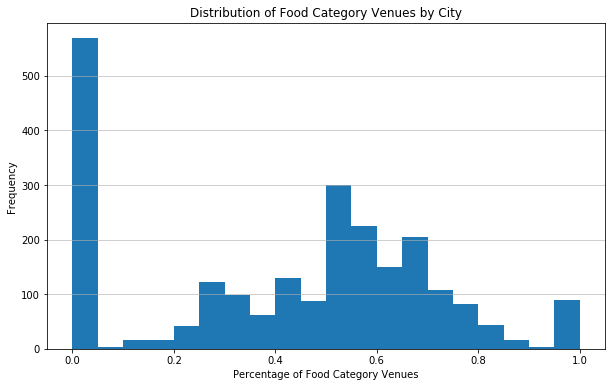

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(x=food_dist,bins=20)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Percentage of Food Category Venues')
plt.ylabel('Frequency')
plt.title('Distribution of Food Category Venues by City')

plt.show()

Throw out the venues where food category equals zero or one. This is either incorrectly labeled, oversaturated with restaurants or it is a highly undesirable location.

In [50]:
food_venue_percentage_filter = food_venue_percentage[(food_venue_percentage['Food_Category'] > 0.00000) & \
                                                     (food_venue_percentage['Food_Category'] < 1.00000)]
food_dist_filter = food_venue_percentage_filter["Food_Category"]

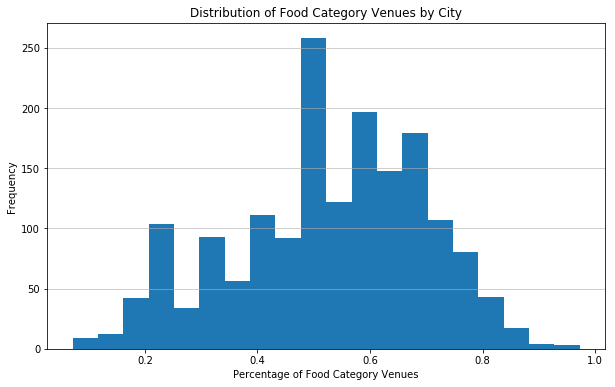

In [51]:
plt.figure(figsize=(10,6))
plt.hist(x=food_dist_filter,bins=20)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Percentage of Food Category Venues')
plt.ylabel('Frequency')
plt.title('Distribution of Food Category Venues by City')

plt.show()

In [52]:
food_dist_filter.describe()

count    1711.000000
mean        0.529666
std         0.166542
min         0.071429
25%         0.423904
50%         0.544917
75%         0.658717
max         0.972973
Name: Food_Category, dtype: float64

In [53]:
display(food_venue_percentage_filter[['Food_Category']].shape)
food_venue_percentage[['Food_Category']].head()

(1711, 1)

Food_Category
City                   
ABILENE        0.586207
ABINGTON       0.000000
ACCOKEEK       0.666667
ACCORD         0.708333
ACTON          0.500000

Move the city index to a row and reformat it so only the first letter is capitalized.

In [54]:
food_cities = food_venue_percentage_filter[["Food_Category"]]
food_cities["City"] = list(map(lambda x: x.title(), food_cities.index.tolist()))
food_cities.reset_index(drop=True, inplace=True)
food_cities.head()

Food_Category      City
0       0.586207   Abilene
1       0.666667  Accokeek
2       0.708333    Accord
3       0.500000     Acton
4       0.666667       Ada

2019 population, population growth, and food category are determined to be the most important feature of a city. 2019 population speaks to degree to which the market is established, population growth provides insight as to how fast the potential base of consumers is growing and food category determines to degree to which the area may be underserved from a restaurant perspective.

In [55]:
merged_data = city_df.merge(food_cities, on="City")
sort_food_cities = merged_data.sort_values(by="Change",ascending=False)

A custom metric is formulated to determine the most desirable city while balancing the three factors of population growth, 2019 population and food category. Each factor is scaled by the maximum value such that they can be assessed equally. Furthermore, the food category feature will be subtracted from one to reflect the fact that smaller values are more desirable. An extension of the F1 score will be used to assess the most desirable city. This will achieve our goal of favoring established cities which provide strong scores for all three values, against small markets which may be growing faster. This computation is as follows:

__Scaled Total Population__ = $\frac{Population Column}{Maximum Population Observed}$

__Scaled Change__ = $\frac{Change Column}{Maximum Change Observed}$

__Scaled Food Category__ = $1 - \frac{Food Category Column}{Maximum Food Category Observed}$

__Modified F1 Score__ = $3 * \frac{Scaled Total Population * Scaled Change * Scaled Food Category}{Scaled Total Population + Scaled Change + Scaled Food Category}$

In [56]:
sort_food_cities["Scaled_Total_Population"] = sort_food_cities["2019estimate"] / max(sort_food_cities["2019estimate"])
sort_food_cities["Scaled_Change"] = sort_food_cities["Change"] / max(sort_food_cities["Change"])
sort_food_cities["Scaled_Food_Category"] = 1 - sort_food_cities["Food_Category"] / max( sort_food_cities["Food_Category"])

sort_food_cities["Metric"] = 3 * (sort_food_cities["Scaled_Total_Population"] * sort_food_cities["Scaled_Change"] * sort_food_cities["Scaled_Food_Category"]) / \
                                 (sort_food_cities["Scaled_Total_Population"] + sort_food_cities["Scaled_Change"] + sort_food_cities["Scaled_Food_Category"])
sort_food_cities.sort_values(by="Metric",ascending=False).head(20)

Unnamed: 0  2019rank           City                 State  2019estimate  \
12          12        13     Fort Worth                    TX        909585   
4            4         5        Phoenix               Arizona       1680992   
6            6         7    San Antonio                    TX       1547253   
18          17        18        Seattle            Washington        753675   
20          19        20     Washington  District of Columbia        705749   
10          10        11         Austin                    TX        978908   
19          18        19         Denver              Colorado        727211   
11          11        12   Jacksonville               Florida        911507   
13          13        14       Columbus                  Ohio        898553   
8            8         9         Dallas                    TX       1343573   
37          36        37        Atlanta               Georgia        506811   
1            1         2    Los Angeles            California       3979576   
35          34        35           Mesa               Arizona        518012   
3            3         4        Houston                    TX       2320268   
23          22        23      Nashville             Tennessee        670820   
27          26        27      Las Vegas                Nevada        651319   
26          25        26       Portland                Oregon        654741   
15          14        15      Charlotte                    NC        885708   
41          39        40          Omaha              Nebraska        478192   
16          15        16  San Francisco            California        881549   

    2010Census  Change  2016 Population Density (people/km2)  \
12      741206   22.72                                 962.0   
4      1445632   16.28                                1200.0   
6      1327407   16.56                                1250.0   
18      608660   23.83                                3245.0   
20      601723   17.29                                4304.0   
10      790390   23.85                                1170.0   
19      600158   21.17                                1746.0   
11      821784   10.92                                 455.0   
13      787033   14.17                                1520.0   
8      1197816   12.17                                1493.0   
37      420003   20.67                                1366.0   
1      3792621    4.93                                3276.0   
35      439041   17.99                                1357.0   
3      2100263   10.48                                1395.0   
23      601222   11.58                                 536.0   
27      583756   11.57                                1818.0   
26      583776   12.16                                1851.0   
15      731424   21.09                                1064.0   
41      408958   16.93                                1296.0   
16      805235    9.48                                7170.0   

    2016 Land Area (km2)  Latitude  Longitude  Food_Category  \
12                 888.1   32.7815   -97.3467       0.416370   
4                 1340.6   33.5722  -112.0901       0.600169   
6                 1194.0   29.4724   -98.5251       0.588100   
18                 217.0   47.6205  -122.3509       0.556586   
20                 158.2   38.9041   -77.0172       0.401187   
10                 809.9   30.3039   -97.7544       0.641967   
19                 397.0   39.7619  -104.8811       0.561803   
11                1935.8   30.3369   -81.6616       0.437500   
13                 565.9   39.9852   -82.9848       0.581916   
8                  882.9   32.7933   -96.7665       0.658335   
37                 345.8   33.7629   -84.4227       0.474505   
1                 1213.9   34.0194  -118.4108       0.633723   
35                 357.2   33.4019  -111.7174       0.496732   
3                 1651.1   29.7866   -95.3909       0.714793   
23                1232.6   36.1718   -8

It is no secret Texas is the fastest growing state in the United States by number of people. It is eventually forecasted to exceed California as the most populous state in the US. Fort Worth meets all our criteria, in that it is a large, established, and expanding market. It also takes the top spot by a considerable margin over the second and third place cities, and huge margin over the rest of the competition. It is certainly a plus that it is located in Texas, a state with a booming population. This ensures there were be an established and growing consumer base for years to come.

Next, I will ensure Fort Worth has adequate data compared to the rest of the cities.

In [57]:
fw_df = total_df[total_df["City"] == "FORT WORTH"]
fort_worth = fw_df.reset_index()
print(f"There are {fort_worth.shape[0]} entries for Fort Worth.")

There are 281 entries for Fort Worth.


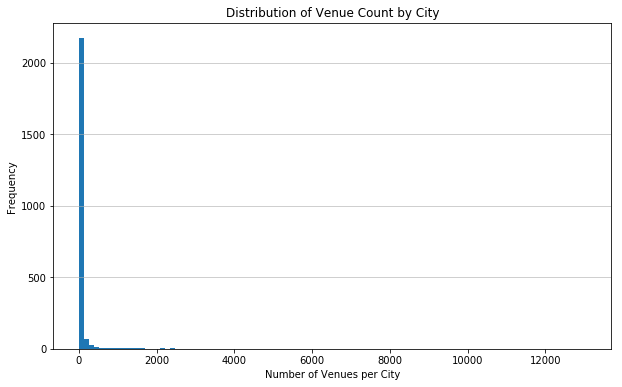

In [58]:
venues_by_city = venue_count["Venue Category"]

plt.figure(figsize=(10,6))
plt.hist(x=venues_by_city,bins=100)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Venues per City')
plt.ylabel('Frequency')
plt.title('Distribution of Venue Count by City')

plt.show()

In [59]:
venues_by_city.describe(percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

count     2367.000000
mean        99.679763
std        546.449275
min          1.000000
10%          1.000000
20%          2.000000
30%          4.000000
40%          5.000000
50%          8.000000
60%         14.000000
70%         24.000000
80%         43.000000
90%        100.000000
95%        288.700000
99%       2125.600000
max      13049.000000
Name: Venue Category, dtype: float64

In [60]:
print(f"This falls in the 95th percentile meaning the 13th largest cities has {round(0.05 * 2367,0)} cities with more venues.")

This falls in the 95th percentile meaning the 13th largest cities has 118.0 cities with more venues.


This is insufficient data to generate a confident recommendation, therefore, the next highest scoring city, Phoenix, is recommended.

In [61]:
phx_df = total_df[(total_df["City"] == "PHOENIX") & (total_df["State"] == "AZ")].reset_index()
print(f"Phoenix returned {phx_df.shape[0]} venues, falling in the 99th percentile.")
print("This is sufficient data to generate a confident recommendation.")

Phoenix returned 2359 venues, falling in the 99th percentile.
This is sufficient data to generate a confident recommendation.


In [62]:
phx_df.head()

index  Unnamed: 0  Zip_Code  Zip_Code Latitude  Zip_Code Longitude  \
0  39360       39360     85021          33.560458         -112.093686   
1  39361       39361     85021          33.560458         -112.093686   
2  39362       39362     85021          33.560458         -112.093686   
3  39363       39363     85029          33.594612         -112.107441   
4  39364       39364     85029          33.594612         -112.107441   

                            Venue  Venue Latitude  Venue Longitude  \
0                 Royal Palm Park       33.558240      -112.090198   
1                     Butler Park       33.560289      -112.089889   
2   Playground At Royal Palm Park       33.558206      -112.090262   
3                   Back Yard BBQ       33.596779      -112.108304   
4  Scottsdale Appliance Repairman       33.592263      -112.110160   

      Venue Category  Unnamed: 0.1     City    County  Distance   Latitude  \
0               park           958  PHOENIX  MARICOPA      0.84  33.560458   
1               park           958  PHOENIX  MARICOPA      0.84  33.560458   
2         playground           958  PHOENIX  MARICOPA      0.84  33.560458   
3          bbq joint           959  PHOENIX  MARICOPA      1.84  33.594612   
4  other repair shop           959  PHOENIX  MARICOPA      1.84  33.594612   

    Longitude State  Food_Category  
0 -112.093686    AZ              0  
1 -112.093686    AZ              0  
2 -112.093686    AZ              0  
3 -112.107441    AZ              1  
4 -112.107441    AZ              0

In [63]:
latitude = city_df[city_df["City"] == "Phoenix"]["Latitude"]
longitude = city_df[city_df["City"] == "Phoenix"]["Longitude"]

map_phx = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, zip_code, venue in zip(phx_df['Venue Latitude'], phx_df['Venue Longitude'], phx_df['Zip_Code'],phx_df['Venue Category']):
    label = '{}, {}'.format(venue, zip_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_phx)  
    
map_phx

The Phoenix venues are plotted above. The zip codes will be plotted next as a sanity check to ensure adequate coverage.

In [64]:
latitude = city_df[city_df["City"] == "Phoenix"]["Latitude"]
longitude = city_df[city_df["City"] == "Phoenix"]["Longitude"]

map_phx = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, zip_code in zip(phx_df['Zip_Code Latitude'], phx_df['Zip_Code Longitude'], phx_df['Zip_Code']):
    label = '{}'.format(zip_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_phx)  
    
map_phx

A visual inspection of these Zip Codes suggest I have adequate coverage of Phoenix.

Next, I will determine the optimal number of clusters using the elbow method. While this method does not always provide a clear answer it does provide additional information. Furthermore, given my application doesn't provide a clear idea of how many clusters are needed, this method becomes more important.

I will use the cost function for K Means defined as the average Euclidean distance between the venue and the assigned cluster. I will iterate from 1 to 15 clusters in attempt to identify the elbow of the graph.

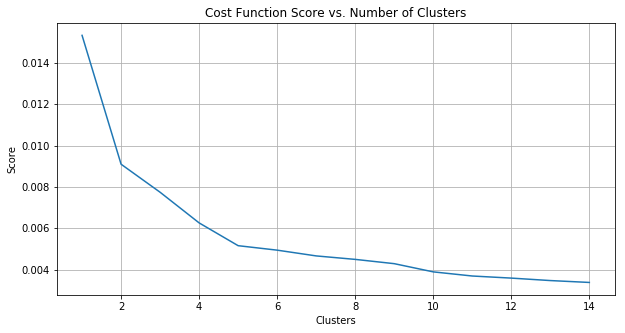

In [65]:
input_data = np.array(phx_df[["Venue Latitude","Venue Longitude"]])
score2 = []
clusters2 = []

# Compute the cost for each number of clusters
for x in np.arange(1,15):  
    
#   Fit the data and assign the clusters
    kmeans2 = KMeans(n_clusters=x, random_state=0).fit(input_data)
    clusters_df = pd.DataFrame(kmeans2.cluster_centers_).reset_index()
    clusters_df.columns = ["Cluster","Cluster_Lat","Cluster_Long"]

#   Assign the labels to the original data set containing the coordinates of the venues
    score_phx_df = phx_df.copy()
    score_phx_df['Cluster Labels'] = kmeans2.labels_
    
#   Merge the data set containing the cluster coordinates and compute the euclidean distance
    score_merge = score_phx_df.merge(clusters_df,left_on="Cluster Labels",right_on="Cluster")
    score_merge["Venue_Score"] = np.sqrt((score_merge["Venue Latitude"] - score_merge["Cluster_Lat"])**2 + \
                                         (score_merge["Venue Longitude"] - score_merge["Cluster_Long"])**2)
    
    score2.append(score_merge["Venue_Score"].mean())
    clusters2.append(x) 
    
# Plot the results
fig, ax1 = plt.subplots(1)
fig.set_size_inches(10,5)

ax1.plot(clusters2,score2)
ax1.set_ylabel('Score')
ax1.set_xlabel('Clusters')
ax1.set_title('Cost Function Score vs. Number of Clusters')
ax1.grid()

plt.show()

Again, there is no correct answer. The elbow appears to be at 5 clusters and this seems to be a reasonable number of clusters with which to segment Phoenix, I will choose 5 clusters.

Finally, 100 different random states are used to compute the Cost Function score for 5 clusters to ensure the optimization algorithm does not get stuck in a local minimum and that the global minimum is found.

In [66]:
input_data = np.array(phx_df[["Venue Latitude","Venue Longitude"]])
results_list = []

# Compute the cost for each number of clusters
for x in np.arange(1,100):  
    
#   Fit the data, assign the clusters and initialize the random state
    kmeans2 = KMeans(n_clusters=5,random_state=x, n_init=100).fit(input_data)
    clusters_df = pd.DataFrame(kmeans2.cluster_centers_).reset_index()
    clusters_df.columns = ["Cluster","Cluster_Lat","Cluster_Long"]

#   Assign the labels to the original data set containing the coordinates of the venues
    score_phx_df = phx_df.copy()
    score_phx_df['Cluster Labels'] = kmeans2.labels_
    
#   Merge the data set containing the cluster coordinates and compute the euclidean distance
    score_merge = score_phx_df.merge(clusters_df,left_on="Cluster Labels",right_on="Cluster")
    score_merge["Venue_Score"] = np.sqrt((score_merge["Venue Latitude"] - score_merge["Cluster_Lat"])**2 + \
                                         (score_merge["Venue Longitude"] - score_merge["Cluster_Long"])**2)
    
    results_list.append({'Clustering Iteration':x,'Clustering Score':score_merge["Venue_Score"].mean(),'Data Fit':kmeans2})
    
results_df = pd.DataFrame(results_list)

In [67]:
results_df['Clustering Score'].unique()

array([0.00515367])

All iterations yielded the same value meaning the global minimum was found and that is was relatively easy to find.

In [68]:
input_data = np.array(phx_df[["Venue Latitude","Venue Longitude"]])
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(input_data)

phx_df['Cluster Labels'] = kmeans.labels_

In [69]:
latitude = city_df[city_df["City"] == "Phoenix"]["Latitude"]
longitude = city_df[city_df["City"] == "Phoenix"]["Longitude"]

kclusters = len(set(phx_df['Cluster Labels']))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(phx_df['Venue Latitude'], phx_df['Venue Longitude'], phx_df['Zip_Code'], phx_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The percentage of food venues for each cluster are as follows:

In [70]:
phx_df.groupby("Cluster Labels").mean()

index    Unnamed: 0      Zip_Code  Zip_Code Latitude  \
Cluster Labels                                                                
0               40776.815233  40776.815233  85052.172543          33.449245   
1               39425.715447  39425.715447  85013.406504          33.513504   
2               64524.619048  36242.904762  85047.333333          33.700815   
3               39794.727273  39794.727273  85030.318182          33.504995   
4               54338.818182  42862.636364  85029.181818          33.429043   

                Zip_Code Longitude  Venue Latitude  Venue Longitude  \
Cluster Labels                                                        
0                      -112.072931       33.448975      -112.072376   
1                      -112.074733       33.513759      -112.075575   
2                      -112.061793       33.700754      -112.061936   
3                      -112.159315       33.505360      -112.160185   
4                      -112.005029       33.430493      -112.004425   

                Unnamed: 0.1   Distance   Latitude   Longitude  Food_Category  
Cluster Labels                                                                 
0                1004.821815   8.531730  33.449245 -112.072931       0.614951  
1                 965.113821   4.300976  33.513504 -112.074733       0.487805  
2                2623.571429   8.747619  33.700815 -112.061793       0.333333  
3                 980.409091   6.190455  33.504995 -112.159315       0.386364  
4                1685.272727  10.435000  33.429043 -112.005029       0.568182

Based on the breakdown of food venues by cluster, clusters 2 and 3 are the most underserved. Given the preference towards a central location, cluster 3 is chosen. Next, I will decide what type of restaurant to recommend. I will determine the least common restaurants by cluster and for all of Phoenix. For the sake of simplicity, I will not consider recommending a restaurant that is not found in Phoenix.

In order to accomplish this, I will first compute the number of occurences of each type of venue in each cluster, and its percent frequency of occurence in each cluster.

In [71]:
# one hot encoding
phx_df_onehot = pd.get_dummies(phx_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
phx_df_onehot['Cluster Labels'] = phx_df['Cluster Labels'] 

# Find the neighborhood columns and move it to the front
cols = phx_df_onehot.columns.tolist()
first_column = ['Cluster Labels']
new_order = first_column + cols[:cols.index('Cluster Labels')] + cols[cols.index('Cluster Labels') + 1 :]
phx_df_onehot = phx_df_onehot[new_order]

phx_df_onehot.head()

Cluster Labels  accessories store  adult boutique  airport lounge  \
0               1                  0               0               0   
1               1                  0               0               0   
2               1                  0               0               0   
3               1                  0               0               0   
4               1                  0               0               0   

   airport service  airport terminal  american restaurant  antique shop  \
0                0                 0                    0             0   
1                0                 0                    0             0   
2                0                 0                    0             0   
3                0                 0                    0             0   
4                0                 0                    0             0   

   arcade  art gallery  ...  trail  train station  \
0       0            0  ...      0              0   
1       0            0  ...      0              0   
2       0            0  ...      0              0   
3       0            0  ...      0              0   
4       0            0  ...      0              0   

   vegetarian / vegan restaurant  video game store  video store  wine bar  \
0                              0                 0            0         0   
1                              0                 0            0         0   
2                              0                 0            0         0   
3                              0                 0            0         0   
4                              0                 0            0         0   

   wine shop  wings joint  women's store  yoga studio  
0          0            0              0            0  
1          0            0              0            0  
2          0            0              0            0  
3          0            0              0            0  
4          0            0              0            0  

[5 rows x 164 columns]

In [72]:
phx_grouped = phx_df_onehot.groupby('Cluster Labels').mean().reset_index()
phx_grouped

Cluster Labels  accessories store  adult boutique  airport lounge  \
0               0            0.00047         0.00000        0.000000   
1               1            0.00000         0.00813        0.000000   
2               2            0.00000         0.00000        0.000000   
3               3            0.00000         0.00000        0.000000   
4               4            0.00000         0.00000        0.022727   

   airport service  airport terminal  american restaurant  antique shop  \
0         0.000000          0.000000             0.062529       0.00000   
1         0.000000          0.000000             0.016260       0.00813   
2         0.000000          0.000000             0.047619       0.00000   
3         0.000000          0.000000             0.000000       0.00000   
4         0.090909          0.068182             0.022727       0.00000   

    arcade  art gallery  ...     trail  train station  \
0  0.00047     0.002351  ...  0.000000       0.002821   
1  0.00000     0.008130  ...  0.000000       0.008130   
2  0.00000     0.000000  ...  0.095238       0.000000   
3  0.00000     0.000000  ...  0.000000       0.000000   
4  0.00000     0.000000  ...  0.000000       0.000000   

   vegetarian / vegan restaurant  video game store  video store  wine bar  \
0                        0.00141          0.000000      0.00000   0.00047   
1                        0.00813          0.000000      0.01626   0.00000   
2                        0.00000          0.000000      0.00000   0.00000   
3                        0.00000          0.022727      0.00000   0.00000   
4                        0.00000          0.000000      0.00000   0.00000   

   wine shop  wings joint  women's store  yoga studio  
0    0.00094     0.000000       0.000940      0.00047  
1    0.00000     0.000000       0.000000      0.00000  
2    0.00000     0.000000       0.000000      0.00000  
3    0.00000     0.022727       0.022727      0.00000  
4    0.00000     0.000000       0.000000      0.00000  

[5 rows x 164 columns]

The percent frequency of each venue for the entire of Phoenix is as follows.

In [73]:
total_venues = pd.DataFrame(phx_df_onehot.sum(axis=0)).T
total_venues_avg = total_venues / total_venues[total_venues.columns[1:]].sum(axis=1)[0]
total_venues_avg.iloc[:,1:]

accessories store  adult boutique  airport lounge  airport service  \
0           0.000424        0.000424        0.000424         0.001696   

   airport terminal  american restaurant  antique shop    arcade  art gallery  \
0          0.001272             0.058075      0.000424  0.000424     0.002543   

   arts & crafts store  ...     trail  train station  \
0              0.00212  ...  0.000848       0.002967   

   vegetarian / vegan restaurant  video game store  video store  wine bar  \
0                       0.001696          0.000424     0.000848  0.000424   

   wine shop  wings joint  women's store  yoga studio  
0   0.000848     0.000424       0.001272     0.000424  

[1 rows x 163 columns]

In [74]:
def return_least_common_venues(row, num_top_venues):
#   filter out venues that don't appear  
    row_categories = row.iloc[1:]
    row_categories = row_categories[row_categories > 0]
    row_categories_sorted = row_categories.sort_values(ascending=True)
#     print(row, row_categories_sorted)
    return row_categories_sorted.index.values[0:num_top_venues]

In [75]:
num_top_venues = 10
least = []

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Cluster Labels'] = phx_grouped['Cluster Labels']

for ind in np.arange(phx_grouped.shape[0]):
    least.append(return_least_common_venues(phx_grouped.iloc[ind, :], num_top_venues))

The least common venues for all 5 clusters are found below.

In [76]:
pd.DataFrame(least,columns=columns[1:])

1st Least Common Venue  2nd Least Common Venue  3rd Least Common Venue  \
0      accessories store    ethiopian restaurant  furniture / home store   
1         adult boutique  gluten-free restaurant                gym pool   
2    american restaurant              theme park            tennis court   
3            gas station        video game store                 theater   
4         airport lounge          sandwich place              restaurant   

          4th Least Common Venue 5th Least Common Venue  \
0                    gas station                gay bar   
1  vegetarian / vegan restaurant    hawaiian restaurant   
2                     sports bar         sandwich place   
3                     sports bar             restaurant   
4                            pub                   pool   

        6th Least Common Venue 7th Least Common Venue 8th Least Common Venue  \
0        general entertainment             hobby shop           intersection   
1            health food store           home service                  hotel   
2  professional & other places                   pool               pharmacy   
3               rental service            pizza place               pharmacy   
4                  planetarium               pharmacy     mexican restaurant   

  9th Least Common Venue 10th Least Common Venue  
0    japanese restaurant                  museum  
1              irish pub     japanese restaurant  
2          moving target                  lawyer  
3             nail salon           moving target  
4           intersection           grocery store

While it is interesting to see the least frequent venues in each cluster, the absence of a type of restaurant does not mean it will not be successful. On the contrary, a new type of restaurant may attract previous customers looking for this type of food or new customers looking to try a new type of food. Next, the least frequent restaurants establishments for all of Phoenix are listed.

In [80]:
Least = total_venues_avg.T.sort_values(by=0,ascending=True).head(75)
Least
for idx, row in Least.iterrows():
    if 'restaurant' in idx:
        print(f"{idx} represents {row[0]*100}% of the total venues in Phoenix")

ethiopian restaurant represents 0.0423908435777872% of the total venues in Phoenix
french restaurant represents 0.0423908435777872% of the total venues in Phoenix
gluten-free restaurant represents 0.0423908435777872% of the total venues in Phoenix
hawaiian restaurant represents 0.0423908435777872% of the total venues in Phoenix
caribbean restaurant represents 0.0847816871555744% of the total venues in Phoenix


The least frequently occurring restaurants in Phoenix include ethiopian, french, gluten-free and hawaiian restaurant. Since they all occur in equal frequency, I will examine their frequency within cluster 3, with lower frequency being preferable.

In [78]:
phx_grouped[["ethiopian restaurant", "french restaurant", "gluten-free restaurant","hawaiian restaurant"]]

ethiopian restaurant  french restaurant  gluten-free restaurant  \
0               0.00047           0.000000                 0.00000   
1               0.00000           0.000000                 0.00813   
2               0.00000           0.000000                 0.00000   
3               0.00000           0.000000                 0.00000   
4               0.00000           0.022727                 0.00000   

   hawaiian restaurant  
0              0.00000  
1              0.00813  
2              0.00000  
3              0.00000  
4              0.00000

None of them are found in cluster 3, and are therefore equally desirable barring further market research. This company has prior experience with French restaurants, so this type of restaurant is chosen over the other four.

In [79]:
print("The zip codes comprising cluster 5 are {}" .format(phx_df[phx_df["Cluster Labels"] == 3]["Zip_Code"].unique().tolist()))

The zip codes comprising cluster 5 are [85051, 85017, 85019, 85031, 85033, 85035]


# Results and Discussion #

Based on the results of the analysis I recommend opening a French Restaurant in Phoenix. Specifically, I recommend opening this restaurant within one of 5 zip codes: 85051, 85017, 85019, 85031, 85033, and 85035. This conclusion was reached as a result of identifying that French restaurants were not found in cluster 3 and very infrequent in Phoenix as whole. It is important to note the limitations and uncertainties of this analysis. This confidence depends on the confidence we have in the foursquare data and the Zip Code API. We are confident in the foursquare data but it is possible we missed zip codes that would have provided more venues. Additionally, it is possible some venues in Phoenix were not obtained.

While Phoenix did provide a lot of data that landed it in the 99% percentile of venues, we did pass over Fort Worth as an option. Fort Worth may have been a more desirable place to open a restaurant given its score, however, it did not return enough data for me to be confident in that score or confident recommending Fort Worth. Our confidence is directly tied to the amount of data gathered and Fort Worth simply did not yield enough data for a city of that size to conclude we received an accurate picture of the venues in Fort Worth.

I decided to use a location based Clustering algorithm because my recommendation involved the physical location within Phoenix. Therefore, I used KMeans to group the venues by location. I chose 5 clusters in order to provide multiple options for the location of this restaurant. The elbow method suggested this was a sweet spot for balancing a minimized cost function without providing too many clusters. I assesed the percentage of food venues within each cluster and each cluster's proximity to the downtown area. I found cluster 3 to meet both criteria. Finally, I needed to decide what type of restaurant to recommend to build in cluster 3. I made the simplifying assumption not to recommend a type of restaurant that was not already present in Phoenix. I also assumed the residents of Phoenix have roughly as similar preference for all restaurants in Phoenix. This is obviously a huge, unrealistic assumption, however, significant steps would have to be taken to ascertain the restaurant preferences of Phoenix residents. This would require some sort of consumer survey or restaurant performance data to determine which restaurants perform the best in Phoenix. Given my assumptions, I looked for restaurants that were underrepresented in Cluster 3 and Phoenix as a whole. The restaurant of type "French" satified this union of low occurence in cluster 3 and Phoenix overall. This union was decided so this restaurant would have less competition for consumers. It must be noted that there is reasonable possibility that a type of restaurant has a low number of occurences because this type of restaurant may be unfavorable to its residents. However, this cannot be concluded without more data.

# Conclusion #

This analysis consisted of filtering the largest cities in America and identifying cities with an established population, fast growth and lower occurence of food establishments. For each city, I obtained a list of Zip codes and their corresponding coordinates by accessing a Zip Code API. Using these coordinates, I accessed foursquare to return all the venues near these coordinates. I defined a list of venues which fell into the criteria of food. I then determined what percentage of the total venues were food venues for each city. I then computed a custom metric based on the F1 score for the three desirable aspects previously mentioned. Fort Worth contained the lowest score, however, it did not yield sufficient data for a city of that size, therefore, I chose the second highest scoring city, Phoenix. This city returned sufficient data to provide me confidence I had an accurate picture of all the venues in Phoenix. I took all the venues and used KMeans to create 5 clusters. I again determined the food venues as a percentage of the total venues for each cluster to determine the optimal location for this restaurant within Phoenix. I identified the third cluster as containing the least amount of restaurants in a central location. Next, I determined the least frequently occurring venues with at least one occurence in Phoenix. I found French Restaurants as one of the least frequently occuring restaurants. Given this company had more experience with French restaurants over the other contenders, I made the recommendation to open a French Restaurant within Cluster 3 in Phoenix, Arizona.